In [4]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# تحميل البيانات
df = pd.read_csv("AraFacts.csv")
df = df[['claim', 'normalized_label']].dropna()

# دالة لتوحيد الحروف
def normalize_arabic(text):
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

# تحميل stop words
arabic_stopwords = set(stopwords.words('arabic'))

# دالة التنظيف النهائية
def preprocess_text(text):
    text = normalize_arabic(text)
    tokens = text.split()  # هذا بدل word_tokenize
    tokens = [t for t in tokens if t not in arabic_stopwords and len(t) > 1]
    return tokens

# تطبيق المعالجة
df['cleaned_tokens'] = df['claim'].apply(preprocess_text)

# عرض النتائج
print(df[['claim', 'cleaned_tokens', 'normalized_label']].head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               claim  \
0  الشركة المالكة للعبة ببجي (PUBG) أعلنت يوم 26 ...   
1  تصريح لمبابي يقول فيه "أريد أن أصبح مثل رونالد...   
2                             وفاة الفنان يوسف شعبان   
3  إضاءة شلالات نياغارا في كندا بألوان العلم الكو...   
4  صورة لأصغر زوجين في الجزائر، تحديدًا من بلدة ت...   
5  ترامب يرفع علم الثورة الأمريكية لعام ١٧٧٦ بدلا...   
6  تركيا تعفي السوريين من تأشيرة الدخول بعد قرار ...   
7  بطلة أفلام هاري بوتر الممثلة البريطانية إيما و...   
8  مقطع فيديو لأسرى حوثيين بينهم أطفال بيد الجيش ...   
9  صورة لطفل يدعى ماريو يونان عمره شهر، أجرى عملي...   

                                      cleaned_tokens normalized_label  
0  [الشركه, المالكه, للعبه, ببجي, PUBG, اعلنت, يو...            False  
1  [تصريح, لمبابي, يقول, اريد, ان, اصبح, رونالدو,...     Partly-false  
2                        [وفاه, الفنان, يوسف, شعبان]             True  
3  [اضاءه, شلالات, نياغارا, كندا, بالوان, العلم, ...     Partly-false  
4  [صوره, لاصغر, زوجين,

In [6]:
from collections import Counter

# تبسيط التصنيف: Fake = False + Partly-false، Real = True
df['label_binary'] = df['normalized_label'].apply(lambda x: 'Fake' if x in ['False', 'Partly-false'] else 'Real')

# تقسيم البيانات حسب التصنيف
fake_tokens = df[df['label_binary'] == 'Fake']['cleaned_tokens']
real_tokens = df[df['label_binary'] == 'Real']['cleaned_tokens']

# دالة استخراج Unigrams
def get_unigrams(token_lists):
    all_unigrams = []
    for tokens in token_lists:
        all_unigrams.extend(tokens)
    return Counter(all_unigrams).most_common(20)

# استخراج أكثر 20 unigram تكرارًا لكل فئة
top_unigrams_fake = get_unigrams(fake_tokens)
top_unigrams_real = get_unigrams(real_tokens)

# عرض النتائج كجدول
df_unigrams = pd.DataFrame({
    'Fake_Unigrams': [x[0] for x in top_unigrams_fake],
    'Fake_Count': [x[1] for x in top_unigrams_fake],
    'Real_Unigrams': [x[0] for x in top_unigrams_real],
    'Real_Count': [x[1] for x in top_unigrams_real]
})

# طباعة النتائج
print(df_unigrams)


   Fake_Unigrams  Fake_Count Real_Unigrams  Real_Count
0            علي        1050        كورونا          53
1           صوره         743           علي          52
2         كورونا         663            ان          27
3          فيديو         499       المستجد          26
4            الي         461           الي          26
5             ان         372        فايروس          23
6         فايروس         224          صوره          22
7        المستجد         219         فيديو          19
8         الرييس         212         كوفيد          16
9           مقطع         205        العالم          15
10          بسبب         190         ترامب          15
11          الله         181          بسبب          15
12           صور         168          رييس          10
13           مصر         165          خلال          10
14         مدينه         151            ضد          10
15          يظهر         144           عام          10
16           عام         141          لقاح           9
17        

In [8]:
from collections import Counter
from nltk.util import ngrams

# فصل الـ tokens حسب الفئة
fake_tokens = df[df['label_binary'] == 'Fake']['cleaned_tokens']
real_tokens = df[df['label_binary'] == 'Real']['cleaned_tokens']

# دالة استخراج Bigrams
def get_bigrams(token_lists):
    all_bigrams = []
    for tokens in token_lists:
        bigrams = ngrams(tokens, 2)
        all_bigrams.extend(bigrams)
    return Counter(all_bigrams).most_common(20)

# تنفيذ على كل فئة
top_bigrams_fake = get_bigrams(fake_tokens)
top_bigrams_real = get_bigrams(real_tokens)

# عرض النتائج كجدول
df_bigrams = pd.DataFrame({
    'Fake_Bigrams': [x[0] for x in top_bigrams_fake],
    'Fake_Count': [x[1] for x in top_bigrams_fake],
    'Real_Bigrams': [x[0] for x in top_bigrams_real],
    'Real_Count': [x[1] for x in top_bigrams_real]
})

print(df_bigrams)


           Fake_Bigrams  Fake_Count       Real_Bigrams  Real_Count
0      (فايروس, كورونا)         215  (كورونا, المستجد)          26
1     (كورونا, المستجد)         215   (فايروس, كورونا)          22
2         (مقطع, فيديو)         176   (المستجد, كوفيد)          12
3     (بفايروس, كورونا)         108    (فيروس, كورونا)           6
4       (فيروس, كورونا)          95    (دونالد, ترامب)           5
5         (فيديو, يظهر)          83       (صوره, تظهر)           5
6      (المستجد, كوفيد)          79  (بفايروس, كورونا)           5
7          (صوره, تظهر)          67      (مقطع, فيديو)           4
8         (فيديو, يصور)          54   (القران, الكريم)           4
9    (الرييس, الاميركي)          46     (الحجر, الصحي)           4
10      (دونالد, ترامب)          40   (انتشار, فايروس)           4
11    (الصحه, العالميه)          39      (شركه, فايزر)           3
12  (الولايات, المتحده)          37      (اصل, افريقي)           3
13         (القبض, علي)          36   (لفيروس, كورونا)        

In [10]:
from collections import Counter
from nltk.util import ngrams

# نفصل الـ tokens حسب الفئة
fake_tokens = df[df['label_binary'] == 'Fake']['cleaned_tokens']
real_tokens = df[df['label_binary'] == 'Real']['cleaned_tokens']

# دالة استخراج Trigrams
def get_trigrams(token_lists):
    all_trigrams = []
    for tokens in token_lists:
        trigrams = ngrams(tokens, 3)
        all_trigrams.extend(trigrams)
    return Counter(all_trigrams).most_common(20)

# تنفيذ الدالة لكل فئة
top_trigrams_fake = get_trigrams(fake_tokens)
top_trigrams_real = get_trigrams(real_tokens)

# عرض النتائج كجدول
df_trigrams = pd.DataFrame({
    'Fake_Trigrams': [x[0] for x in top_trigrams_fake],
    'Fake_Count': [x[1] for x in top_trigrams_fake],
    'Real_Trigrams': [x[0] for x in top_trigrams_real],
    'Real_Count': [x[1] for x in top_trigrams_real]
})

# طباعة النتائج
print(df_trigrams)


                  Fake_Trigrams  Fake_Count               Real_Trigrams  \
0     (فايروس, كورونا, المستجد)         131   (فايروس, كورونا, المستجد)   
1      (كورونا, المستجد, كوفيد)          78    (كورونا, المستجد, كوفيد)   
2    (بفايروس, كورونا, المستجد)          63    (انتشار, فايروس, كورونا)   
3           (مقطع, فيديو, يظهر)          37  (بفايروس, كورونا, المستجد)   
4      (منظمه, الصحه, العالميه)          34        (تلقي, لقاح, فايروس)   
5     (كورونا, المستجد, كوفيد_)          23      (لقاح, فايروس, كورونا)   
6      (انتشار, فايروس, كورونا)          18          (شخص, يودي, حركات)   
7           (رجب, طيب, اردوغان)          18         (رييس, شركه, فايزر)   
8            (التركي, رجب, طيب)          17   (فريق, يوفنتوس, الايطالي)   
9     (اصابته, بفايروس, كورونا)          17  (الرييس, الامريكي, دونالد)   
10    (الاميركي, دونالد, ترامب)          16   (الامريكي, دونالد, ترامب)   
11   (الرييس, الاميركي, دونالد)          15  (لفايروس, كورونا, المستجد)   
12          (مقطع, فيديو,

In [12]:
pip install matplotlib wordcloud arabic_reshaper python-bidi


Note: you may need to restart the kernel to use updated packages.


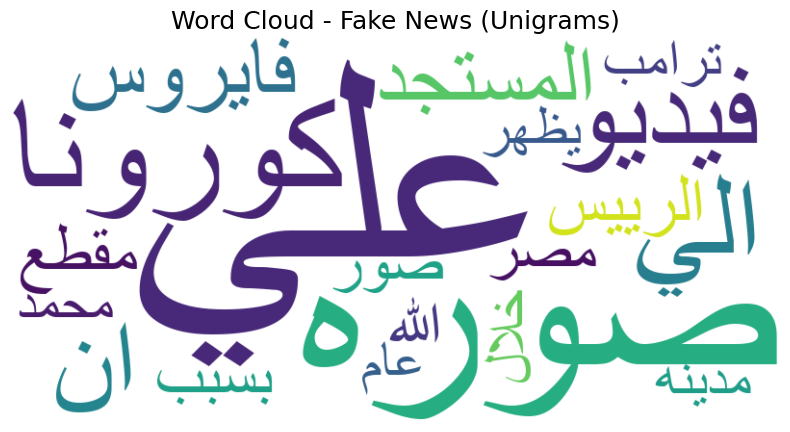

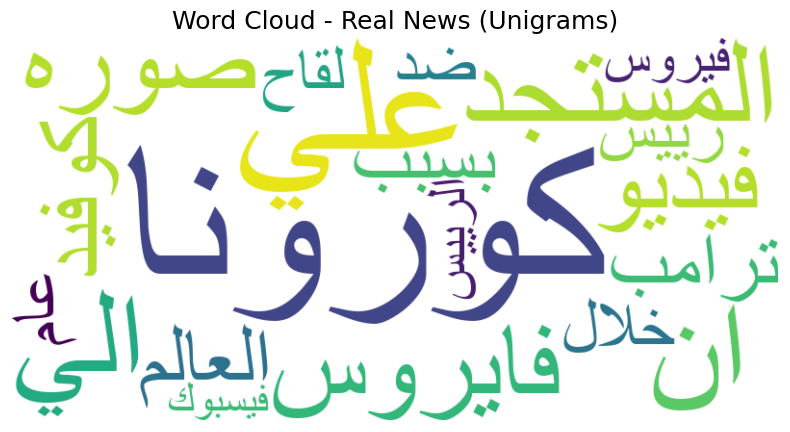

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# دالة تجهيز البيانات للورد كلاود
def generate_wordcloud(freq_dist, title):
    reshaped_text = {
        get_display(arabic_reshaper.reshape(' '.join(k)) if isinstance(k, tuple) else arabic_reshaper.reshape(k)): v
        for k, v in freq_dist
    }
    wc = WordCloud(font_path='arial', background_color='white', width=800, height=400).generate_from_frequencies(reshaped_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

# Word Cloud للأخبار الكاذبة - Unigrams
generate_wordcloud(top_unigrams_fake, 'Word Cloud - Fake News (Unigrams)')

# Word Cloud للأخبار الصحيحة - Unigrams
generate_wordcloud(top_unigrams_real, 'Word Cloud - Real News (Unigrams)')


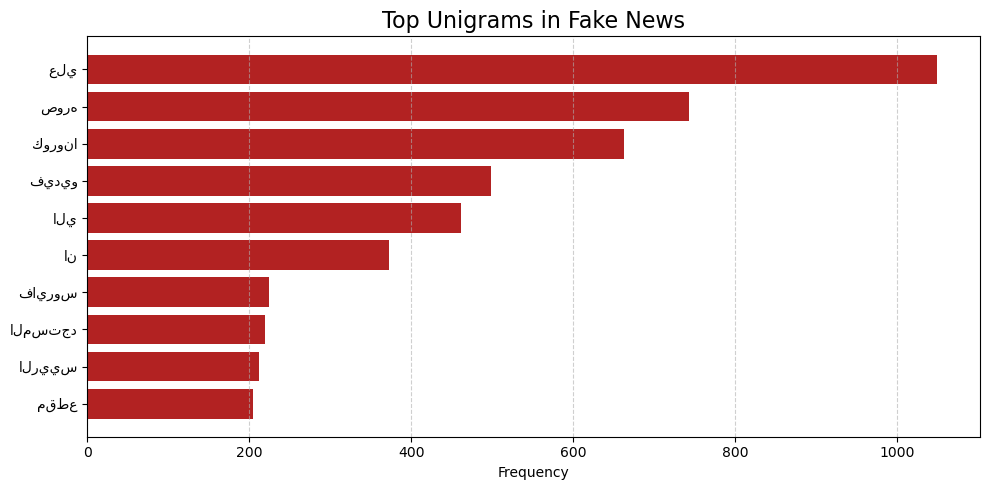

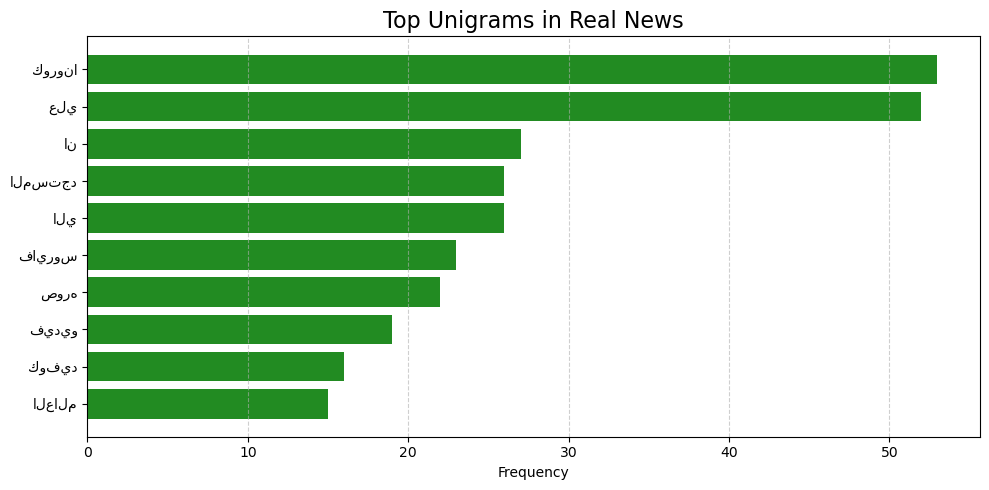

In [16]:
import matplotlib.pyplot as plt

# تجهيز البيانات للبار شارت
def plot_bar_chart(freq_list, title, color):
    words = [' '.join(k) if isinstance(k, tuple) else k for k, v in freq_list[:10]]
    counts = [v for k, v in freq_list[:10]]
    
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], counts[::-1], color=color)
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# رسم الشارت للأخبار الكاذبة
plot_bar_chart(top_unigrams_fake, "Top Unigrams in Fake News", "firebrick")

# رسم الشارت للأخبار الحقيقية
plot_bar_chart(top_unigrams_real, "Top Unigrams in Real News", "forestgreen")


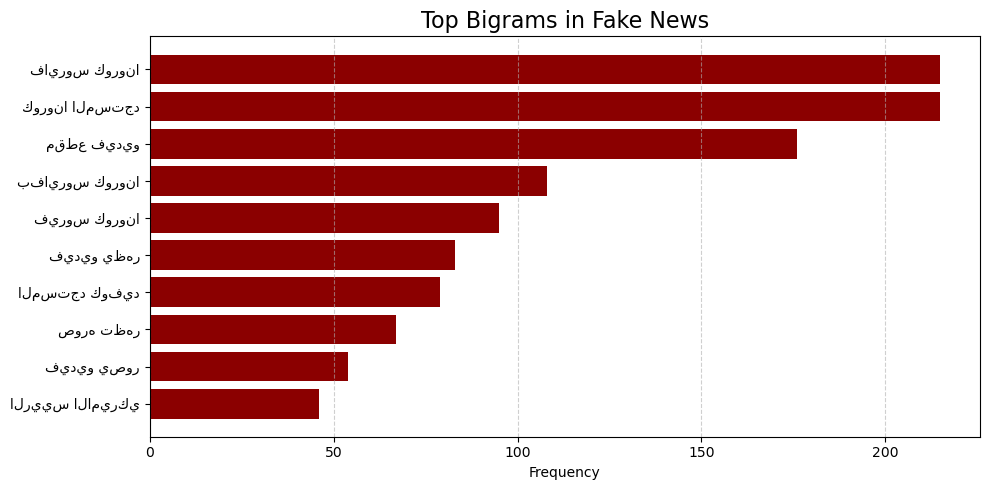

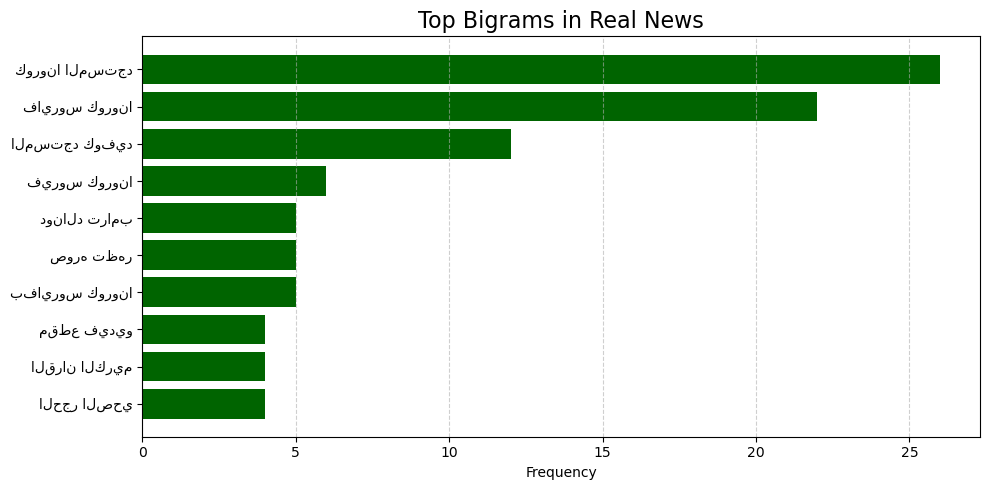

In [18]:
# Bigrams Bar Chart
plot_bar_chart(top_bigrams_fake, "Top Bigrams in Fake News", "darkred")
plot_bar_chart(top_bigrams_real, "Top Bigrams in Real News", "darkgreen")


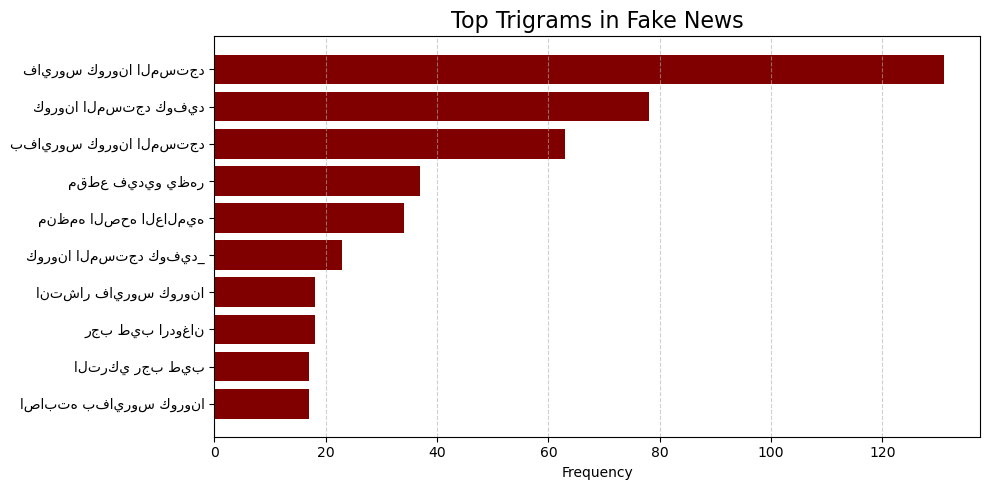

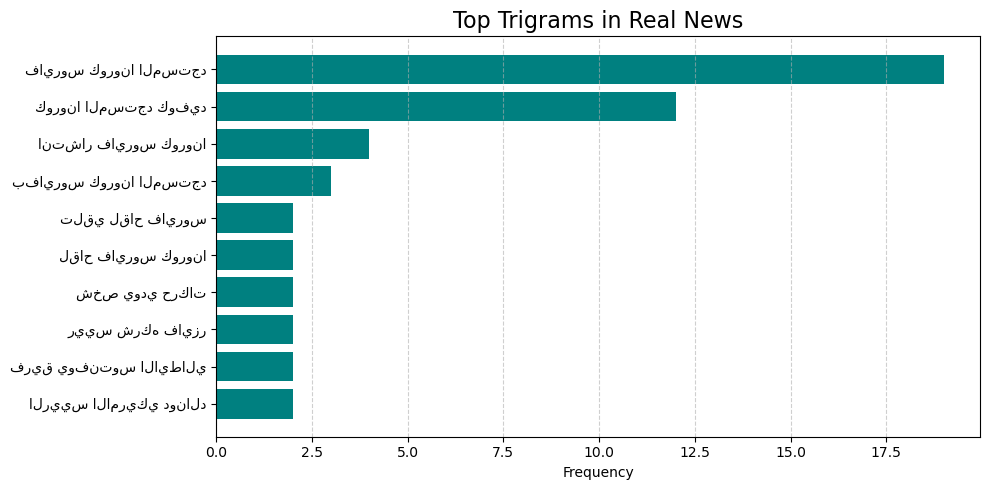

In [20]:
# Trigrams Bar Chart
plot_bar_chart(top_trigrams_fake, "Top Trigrams in Fake News", "maroon")
plot_bar_chart(top_trigrams_real, "Top Trigrams in Real News", "teal")
